In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# The GPU id to use, usually either "0" or "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"   
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)#动态分配gpu别让tf一下占满

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# a = tf.random.uniform(shape=(10,100,50),minval= -0.5,maxval=0.5,dtype=tf.float32)
# x = tf.keras.layers.LSTM(100)(a)
# x = tf.keras.layers.Dense(10)(x)
# x = tf.nn.softmax(x)

Sequential model (顺序模型)一层层搭积木
Functional model (函数模型)模型有残差等等需要函数式
Subclassing model (子类化模型)自定义模型 最为高级
以下只介绍函数式和子类化模型
在这之前先对python类继承进行练习

　　如果我们要给实例 c 传参，我们就要使用到构造函数，那么构造函数该如何继承，同时子类中又如何定义自己的属性？

继承类的构造方法：

        1.经典类的写法： 父类名称.__init__(self,参数1，参数2，...)

        2. 新式类的写法：super(子类，self).__init__(参数1，参数2，....)

In [4]:
class Person(object):
    def __init__(self,name,age):#构造函数自动调用，相当于你调用 Person(name,age)
        self.name  = name#self是一个实例你可以把它当一个参数为什么
        #比如 a = Person('q',21) c = Person('z',22)时，我要区分a和c这两个实例需要self参数可理解为是 a = Person(a,'q',21)
        #c = Person(c,'z',22) 那self.age = age也很好理解了 相当于a.age = 传入的形参age也就是'q'
        self.age = age
        self.weight = 'weight'
    def talk(self,x):
        print(x+" is talking....")#加+和，都可以‘，’自带一个空格如下
    def walk(self):
        print('is walking...')

class Chinese (Person):
    def __init__(self,name,age,language):
        super(Chinese,self).__init__(name,age)#b =Chinese('n',23,'chinese') Person看来:谁继承？Chinese类 实例是？b
        self.language = language#Chinese 类自己的属性
        print("info: ",self.age,self.language)
    def talk(self):#重构Person中的talk函数重构当然不会对父函数有影响，但再调用Chinese中的talk就是重构后的了
        print(self.name,'is speaking chinese')
a = Person('q',21)
c = Person('z',22)
a.talk(a.name)
b = Chinese('n',23,'chinese')
b.talk()#调用的重构后的talk
b.walk()#调用父类Person的walk
c.talk(a.name)#注意这里证实了self的作用就是实例的参数a.name出来的就是a的name

q is talking....
info:  23 chinese
n is speaking chinese
is walking...
q is talking....


接下来看看functional model
Keras 函数式 API 是一种比 tf.keras.Sequential API 更加灵活的模型创建方式。
函数式 API 可以处理具有非线性拓扑的模型、具有共享层的模型，以及具有多个输入或输出的模型。
那不如看个多输入的层计算图

In [5]:
inputs1 = tf.keras.Input(shape = (32,))#为计算图创建一个输入节点，先假定样本形状（32，）
inputs2 = tf.keras.Input(shape = (32,))
print(inputs1.shape)
print(inputs1.dtype)

(None, 32)
<dtype: 'float32'>


In [6]:
dense = layers.Dense(64,activation='relu')
x1 = dense(inputs1)#为计算图添加节点注意指向 相当于x1 = layers.Dense(64, activation='relu')(inputs1)
#知道为啥这么写了把为啥叫函数式了吧
x2 = dense(inputs2)

In [7]:
x = tf.concat?

In [8]:
x = tf.concat([x1,x2],axis= -1)#沿着某一维度连接tensor axis = -1就是倒数第一个维度
x.shape

TensorShape([None, 128])

In [9]:
x = layers.Dense(32,activation='relu')(x)
prediction = layers.Dense(10)(x)

In [11]:
model = tf.keras.Model(inputs = [inputs1,inputs2], outputs = prediction)#通过在层计算图中指定模型的输入和输出来创建 Model

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           2112        input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_concat (TensorFlowO [(None, 128)]        0           dense[0][0]                  

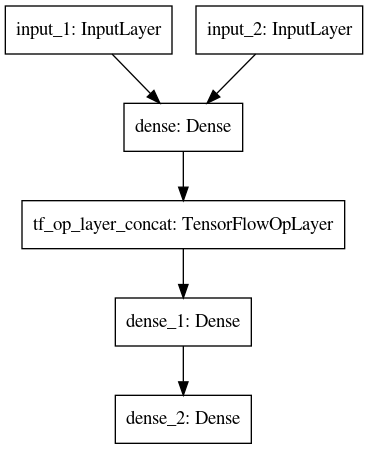

In [14]:
tf.keras.utils.plot_model(model,'a functional model.png')#输出计算图看看

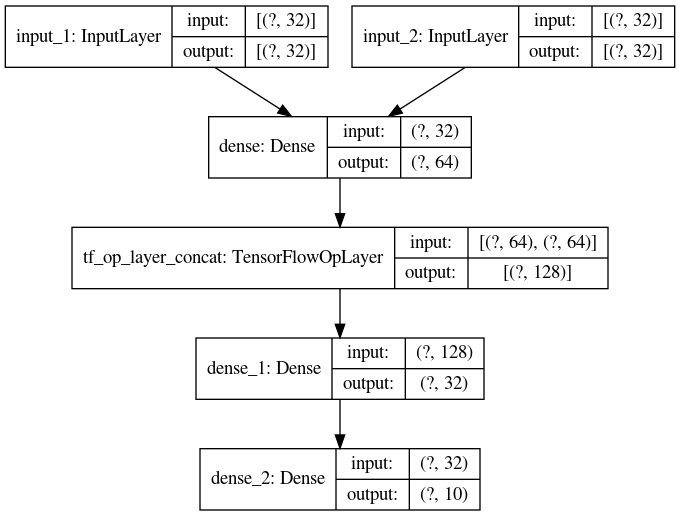

In [15]:
tf.keras.utils.plot_model(model,'a functional model info.png',show_shapes=True)#输出计算图看看2

模型子类化 

通过子类化tf.keras.Model和定义自己的前向传播模型来构建完全可定制的模型。

和eager execution模式相辅相成。可以自定义层layer也可以自定义model
详情可以看https://www.tensorflow.org/guide/keras/custom_layers_and_models#model_%E7%B1%BB
有非常多可自定义的比如让权重不可训练（后向传播不参与不更新）
让某些层dropout等在训练和预测时有不同行为
层递归 等等方法

In [9]:
class Linear1(layers.Layer):#自定义w，b 和前向传播
    def __init__ (self, units = 32, input_dim =32):
        super(Linear1,self).__init__()#继承layers.Layer父类
        self.w = self.add_weight(
            shape=(input_dim,units),initializer='random_normal',trainable=True#add_weight可以方便定义权重初始化 shape等等
            #trainable =False则是不可训练权重
        )
        self.b = self.add_weight(
            shape=(units,),initializer = 'zeros',trainable = True)
    
    def call(self,inputs):#没仔细看原码不过应该是重构了call前向传播这个函数
        return tf.matmul(inputs,self.w) + self.b#tf.matmul矩阵乘法 
    #注意这不是逻辑回归2分类一个输出而是n个输出
    #注意为什么是Xw+b不是wX+b 因为数学计算时在一元时我们默认x = (x1,x2,x3...xd)T是列向量
    #数据x是mxd进来的数据是1xd的行向量 w是dxn b是nx1列向量 so xw+b才是正解 多元时Xw那个时一样的

最佳做法：将权重创建推迟到得知输入的形状之后
在许多情况下，您可能事先不知道输入的大小，并希望在得知该值时（对层进行实例化后的某个时间）再延迟创建权重。
在 Keras API 中，我们建议您在层的 build(self, inputs_shape) 方法中创建层的权重。如下所示：
这样在创建实例时w和b就不会被预先创建
当对层进行实例化真有输入时再创建w和b 原keras里后面层也不用预先定义输入层可能相似写法

实现自己的层的最佳方法是扩展tf.keras.Layer类并实现：

__init__()函数，你可以在其中执行所有与输入无关的初始化
build()函数，可以获得输入张量的形状，并可以进行其余的初始化
call()函数，构建网络结构，进行前向传播

关于tf.nn.relu 和tf.keras.activations.relu区别
tf.nn.relu is a TensorFlow specific whereas tf.keras.activations.relu has more uses in Keras own library. If I create a NN with only TF, I will most probably use tf.nn.relu and if I am creating a Keras Sequential model then I will use tf.keras.activations.relu.
而且tf2.0里 tf.kearas.activation.relu可调参数多

In [10]:
class Linear2(layers.Layer):
    def __init__ (self,units = 32):
        super(Linear2,self).__init__()
        self.units = units#定义了属性units默认32
    
    def build(self,input_shape):
        self.w = self.add_weight(shape = (input_shape[-1],self.units),
                                 initializer='random_normal',
                                 trainable= True)
        self.b = self.add_weight(shape= (self.units,),
                                 initializer = 'random_normal',
                                 trainable = True)
    def call(self,inputs):
        x = tf.matmul(inputs,self.w) + self.b#tf.matmul矩阵乘法 
        x = tf.keras.activations.relu(x,alpha=0.0, max_value=None, threshold=0)
        return x

In [11]:
#linear_layer = Linear1(32,32)#这个显存加了300多m
#linear_layer = Linear2(32)#这个显存基本没变 显然这个好一些

接下来model子类化

In [20]:
class MyModel(tf.keras.Model):
    def __init__ (self,num_classes = 10):
        super(MyModel,self).__init__(name = 'my_model')
        self.num_classes = num_classes
        #self.dense_1 = Linear2(32)
        self.dense_1 = layers.Dense(32, activation='relu') 
        self.dense_2 = layers.Dense(num_classes)
    
    def call(self,inputs):
        x = self.dense_1(inputs)
        x = self.dense_2(x)
        return x

In [28]:
inputs3 = tf.keras.Input(shape = (10,32))#为计算图创建一个输入节点，先假定样本形状（32，）
my_model = MyModel(num_classes=5)
my_model.build((10,32))
my_model.call(inputs3)
my_model.summary()#只build只能输入input_shape,并不知道具体数据进去了这些层怎么用的。
#所以不知道每层output shape 所以会输出为 multiple ，call调用了之后输入一个定义好的input,这样才知道具体output shape

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 10, 32)            1056      
_________________________________________________________________
dense_20 (Dense)             (None, 10, 5)             165       
Total params: 1,221
Trainable params: 1,221
Non-trainable params: 0
_________________________________________________________________
